In [1]:
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_style("whitegrid")

In [15]:
adata = ad.read_h5ad("out/results/ROSMAP_scAGG_results_rep1.h5ad")

In [71]:
ddata = adata.obs.groupby("Donor ID").first().reset_index()
ddata.drop(columns=["Supertype", "cell_type_high_resolution"], inplace=True)

ddata["cogdx"] = ddata["cogdx"].map({
    1: "NCI",
    2: "MCI",
    3: "MCI+",
    4: "AD",
    5: "AD+",
    6: "Other",
})

ddata["msex"] = ddata["msex"].map({
    1: "Male",
    0: "Female",
})

ddata["race"] = ddata["race"].map({
    1: "White",
    2: "Af. Am.",  # Black or African American
    3: "American Indian or Alaska Native",
    4: "Native Hawaiian or Other Pacific Islander",
    5: "Asian",
    6: "Other",
    7: "Unknown",
})

# append spanish if present
# ddata["race"] = ddata["race"] + ddata["spanish"].map({
#     1: " (+ Spanish)",
#     0: "",
# })

for donor in ddata["Donor ID"].unique():
    if any(ddata.loc[ddata["Donor ID"] == donor, "spanish"] == 1):
        ddata.loc[ddata["Donor ID"] == donor, "race"] = "Hisp."  # Hispanic or Latino

ddata.drop(columns=["spanish"], inplace=True)

ddata["braaksc"] = ddata["braaksc"].map({
    0: "0",
    1: "I",
    2: "II",
    3: "III",
    4: "IV",
    5: "V",
    6: "VI",
})

ddata["ceradsc"] = ddata["ceradsc"].map({
    1: "Definite",
    2: "Probable",
    3: "Possible",
    4: "No AD",
})

ddata["niareagansc"] = ddata["niareagansc"].map({
    1: "High",
    2: "Intermediate",
    3: "Low",
    4: "No AD",
})

ddata["n_cells"] = pd.Series(
    [adata.obs["Donor ID"].value_counts()[donor] for donor in ddata["Donor ID"]],
)

plot_cols = ["Label", "study", "msex", "race", "ceradsc", "niareagansc",
              "cogdx", "braaksc", "gpath","age_death", "educ", "n_cells"]
ddata[plot_cols]

,Label,study,msex,race,ceradsc,niareagansc,cogdx,braaksc,gpath,age_death,educ,n_cells
0,Other,ROS,Male,White,No AD,Low,AD,I,0.034177,85.549624,12,3377
1,Other,MAP,Male,White,Probable,Intermediate,NCI,IV,0.905404,87.928816,12,5463
2,Other,MAP,Female,White,Definite,Intermediate,MCI,II,0.470629,95.589322,13,7487
3,Other,MAP,Male,White,Probable,Intermediate,MCI,IV,0.751286,86.973306,13,4101
4,AD,MAP,Female,White,Probable,Intermediate,AD,V,1.429841,88.528405,12,4344
...,...,...,...,...,...,...,...,...,...,...,...,...
334,Other,MAP,Female,White,No AD,Low,MCI,II,0.018161,86.603696,16,14780
335,CT,MAP,Male,White,No AD,Low,NCI,III,0.050919,85.796030,19,5396
336,Other,MAP,Male,White,Probable,Intermediate,MCI,III,0.400123,85.826146,16,2586
337,CT,MAP,Female,White,No AD,Low,NCI,I,0.008729,82.409309,12,4904


In [88]:
ddata = ddata.sort_values(by="Label").reset_index(drop=True)

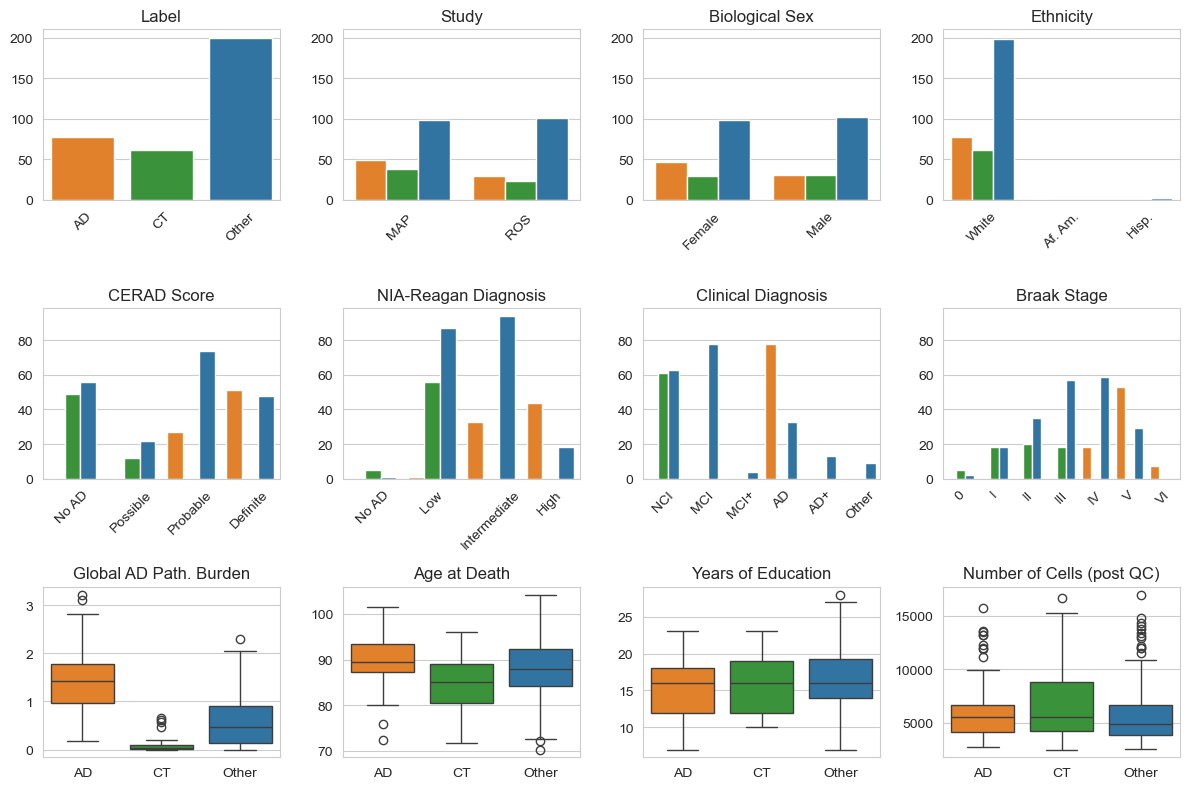

In [97]:
hue_order = ["AD", "CT", "Other"]
palette = sns.color_palette("tab10", n_colors=len(hue_order))  # AD, CT, Other
palette = [palette[1], palette[2], palette[0]]  # Reorder to AD, Other, CT



# map the names:
col_names = {
    "Label": "Label",
    "study": "Study",
    "cogdx": "Clinical Diagnosis",
    "age_death": "Age at Death",
    "educ": "Years of Education",
    "msex": "Biological Sex",
    "race": "Ethnicity",
    "braaksc": "Braak Stage",
    "ceradsc": "CERAD Score",
    "gpath": "Global AD Path. Burden",
    "niareagansc": "NIA-Reagan Diagnosis",
    "n_cells": "Number of Cells (post QC)",
}

col_orders = {
    "Label": ["AD", "CT", "Other"],
    "cogdx": ["NCI", "MCI", "MCI+", "AD", "AD+", "Other"],
    "braaksc": ["0", "I", "II", "III", "IV", "V", "VI"],
    "ceradsc": ["No AD", "Possible", "Probable", "Definite"],
    "niareagansc": ["No AD", "Low", "Intermediate", "High"],
}

fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(12, 8))
axs = axs.flatten()

axs[0].sharey(axs[1])
axs[1].sharey(axs[2])
axs[2].sharey(axs[3])

axs[4].sharey(axs[5])
axs[5].sharey(axs[6])
axs[6].sharey(axs[7])

for i, col in enumerate(plot_cols):
    assert col in ddata.columns, f"Column {col} not found in ddata"

    if ddata[col].dtype == "object" or ddata[col].dtype.name == "category":
        order = col_orders[col] if col in col_orders else None
        sns.countplot(data=ddata, x=col, ax=axs[i], hue="Label", legend=False, hue_order=hue_order, order=order, palette=palette)
        axs[i].tick_params(axis='x', rotation=45)

    elif ddata[col].dtype in ["int64", "float64"]:
        # sns.histplot(data=ddata, x=col, ax=axs[i], kde=False, hue="Label", legend=False, hue_order=hue_order)

        sns.boxplot(data=ddata, x="Label", y=col, ax=axs[i], hue="Label", hue_order=hue_order, palette=palette)

    else:
        raise ValueError(f"Unsupported data type for column {col}: {ddata[col].dtype}")
    
    axs[i].set_title(col_names[col])
    axs[i].set_xlabel("")
    axs[i].set_ylabel("")

plt.tight_layout()
plt.savefig("out/figures/fig_demographics.pdf")
plt.show()